In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import os
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from src.helpers import *
from src.visualize import *
from src.trainer import *
from Models.models import *
from Models.SimpleRNN_NC import SimpleRNN_NC

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from copy import deepcopy
import torch.utils.data as data
from torch.utils.data import Dataset

import pickle
import math

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#@title Helper functions for plotting (run this cell!)
sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])

In [3]:
# Helper function to convert between numpy arrays and tensors
to_t = lambda array: torch.tensor(array, device='cpu', dtype=dtype)  #device
to_t_eval =  lambda array: torch.tensor(array, device='cuda', dtype=dtype)  #device
from_t = lambda tensor: tensor.to("cpu").detach().numpy()

## Load data

In [4]:
data_path = './Data/Processed_Data/Tidy_Sansa_13_04.pkl'

with open(data_path, 'rb') as file:
    df = pickle.load(file)

In [5]:
baseline_df = df.loc[df.type == 'BASELINE'].reset_index()

In [6]:
stim_df = df.loc[df.type == 'TONIC'].reset_index()

## Try Simple RNN

In [7]:
X_train, y_train, X_val, y_val, X_test, y_test, info_train, info_val, info_test = train_test_split(stim_df, train_variable = 'both_rates', 
                                                                                                   target_variable = 'target_pos', num_folds = 5)

Test trials  8
Val trials 7


In [8]:
# Test one of the folds first
fold_num = 'fold0'
fold = 0

print('We are testing the optimization method on fold ', fold)

seq_length = 75
X_train = X_train[fold_num]
X_val = X_val[fold_num]
X_test = X_test[fold_num]
y_test = y_test[fold_num]
y_train = y_train[fold_num]
y_val = y_val[fold_num]

# Reshape x_train to match the number of columns in the model's input layer
xx_train = X_train.reshape(X_train.shape[0] // seq_length, seq_length, X_train.shape[1])  
# Reshape y_train to match the number of neurons in the model's output layer
yy_train = y_train.reshape(y_train.shape[0] // seq_length, seq_length, y_train.shape[1])  

xx_val = X_val.reshape(X_val.shape[0] // seq_length, seq_length, X_val.shape[1])  
yy_val = y_val.reshape(y_val.shape[0] // seq_length, seq_length, y_val.shape[1])  

xx_test = X_test.reshape(X_test.shape[0] // seq_length, seq_length, X_test.shape[1])  
yy_test = y_test.reshape(y_test.shape[0] // seq_length, seq_length, y_test.shape[1])  



We are testing the optimization method on fold  0


In [9]:
# Define hyperparameters

# Specify that we want our tensors on the GPU and in float32
device = torch.device('cuda:0') #suposed to be cuda
dtype = torch.float32
path_to_models = './Models'

num_dim_output = y_train.shape[1]
num_features = X_train.shape[1]

seed = 42
torch.manual_seed(seed)

seq_length = 75

#Hyperparameters objective and regularization
alpha_reg = 1.21e-6
l1_ratio_reg = 0.394

lr = 0.0001 # 0.00193
loss_function = huber_loss
delta = 8  # hyperparameter for huber loss

# Hyperparameters LSTM class
hidden_units = 10
num_layers = 1
#input_size = 31 Not for now, only if I need a linear layer before the RNN

#Other training hyperparameters
lr_gamma= 1.437 #for scheduler
lr_step_size = 10 #for scheduler

seq_length_LSTM= 10
batch_size_train= 25
batch_size_val = 25

**RNN Parameters**

input_size – The number of expected features in the input x

hidden_size – The number of features in the hidden state h

num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two RNNs together to form a stacked RNN, with the second RNN taking in outputs of the first RNN and computing the final results. Default: 1

nonlinearity – The non-linearity to use. Can be either 'tanh' or 'relu'. Default: 'tanh'

bias – If False, then the layer does not use bias weights b_ih and b_hh. Default: True

batch_first – If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Note that this does not apply to hidden or cell states. See the Inputs/Outputs sections below for details. Default: False

dropout – If non-zero, introduces a Dropout layer on the outputs of each RNN layer except the last layer, with dropout probability equal to dropout. Default: 0

bidirectional – If True, becomes a bidirectional RNN. Default: False

In [10]:
#model = CausalRNN(input_size= num_features, hidden_size = hidden_units, num_layers= num_layers, output_dim=num_dim_output, dropout= 0.3)

In [18]:
from hypnettorch.mnets import SimpleRNN

hidden_units = 20
input_rec = 50
seq_length_LSTM = 16

model = SimpleRNN_NC(n_in=num_features, rnn_layers=(hidden_units,), 
                  fc_layers_pre=(input_rec,), fc_layers=(num_dim_output,),
                use_lstm = True, no_weights = False, dropout=0.2).to(device) 
#Here we use no_weights = False to try to train the model only on baseline data

Creating a simple RNN with 8913 weights.


In [19]:
xx_train = to_t(xx_train)
yy_train = to_t(yy_train)
xx_val = to_t(xx_val)
yy_val = to_t(yy_val)

/tmp/ipykernel_294359/815769189.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  to_t = lambda array: torch.tensor(array, device='cpu', dtype=dtype)  #device
/tmp/ipykernel_294359/815769189.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  to_t = lambda array: torch.tensor(array, device='cpu', dtype=dtype)  #device
/tmp/ipykernel_294359/815769189.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  to_t = lambda array: torch.tensor(array, device='cpu', dtype=dtype)  #device
/tmp/ipykernel_294359/815769189.py:2: UserWarning: To copy co

In [20]:
train_losses, val_losses = \
    train_model(model, xx_train,yy_train,
                xx_val, 
                yy_val,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = 8,                 
                regularizer= reg_hnet,
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg, # CAREFUL WITH INTEGERS
                early_stop = 5,
                
                )

/home/nerea/CL_UpperLimb_Control/src/trainer.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y)
/home/nerea/CL_UpperLimb_Control/src/trainer.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X)
/home/nerea/CL_UpperLimb_Control/src/trainer.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y)
/home/nerea/CL_UpperLimb_Control/src/trainer.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.cl

Epoch 000 Train 0.0328 Val 0.0347
Epoch 001 Train 0.0307 Val 0.0338
Epoch 002 Train 0.0291 Val 0.0330
Epoch 003 Train 0.0278 Val 0.0322
Epoch 004 Train 0.0265 Val 0.0318
Epoch 005 Train 0.0256 Val 0.0312
Epoch 006 Train 0.0245 Val 0.0308
Epoch 007 Train 0.0237 Val 0.0302
Epoch 008 Train 0.0228 Val 0.0298
Epoch 009 Train 0.0221 Val 0.0292
Epoch 010 Train 0.0212 Val 0.0290
Epoch 011 Train 0.0204 Val 0.0288
Epoch 012 Train 0.0197 Val 0.0283
Epoch 013 Train 0.0189 Val 0.0280
Epoch 014 Train 0.0184 Val 0.0277
Epoch 015 Train 0.0177 Val 0.0275
Epoch 016 Train 0.0171 Val 0.0272
Epoch 017 Train 0.0169 Val 0.0269
Epoch 018 Train 0.0165 Val 0.0267
Epoch 019 Train 0.0161 Val 0.0265
Epoch 020 Train 0.0159 Val 0.0265
Epoch 021 Train 0.0156 Val 0.0266
Epoch 022 Train 0.0154 Val 0.0264
Epoch 023 Train 0.0153 Val 0.0262
Epoch 024 Train 0.0153 Val 0.0262
Epoch 025 Train 0.0152 Val 0.0263
Epoch 026 Train 0.0152 Val 0.0263
Epoch 027 Train 0.0152 Val 0.0263
Epoch 028 Train 0.0153 Val 0.0264
Decrease LR
Ep

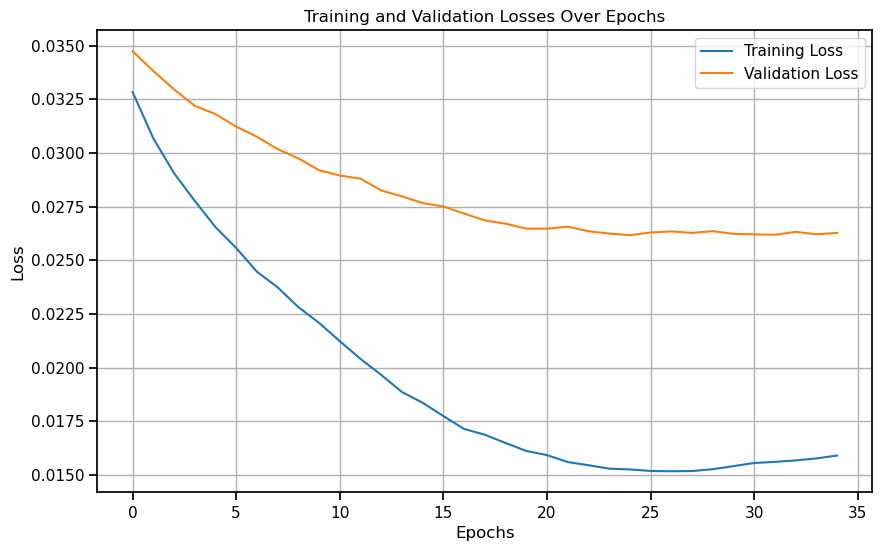

In [21]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [22]:
 # Move the test stimulus and measured rates to the GPU
xx_train = to_t_eval(xx_train)
yy_train = to_t_eval(yy_train)
xx_val = to_t_eval(xx_val)
yy_val = to_t_eval(yy_val)
xx_test = to_t_eval(xx_test)
yy_test = to_t_eval(yy_test)


/tmp/ipykernel_294359/815769189.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  to_t_eval =  lambda array: torch.tensor(array, device='cuda', dtype=dtype)  #device
/tmp/ipykernel_294359/815769189.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  to_t_eval =  lambda array: torch.tensor(array, device='cuda', dtype=dtype)  #device
/tmp/ipykernel_294359/815769189.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  to_t_eval =  lambda array: torch.tensor(array, device='cuda', dtype=dtype)  #device
/tmp/ipykernel_294359/815769189.py:3: Us

In [23]:
y_pred = model(xx_val)
y_array = yy_val.detach().cpu().numpy()
y_pred_array = y_pred.detach().cpu().numpy()

# Reshape tensors to 2D arrays (flatten the batch and sequence dimensions)
y_pred_2D = y_pred_array.reshape(-1, y_pred_array.shape[-1])
y_true_2D = y_array.reshape(-1, y_array.shape[-1])

In [24]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train, yy_train, xx_val, yy_val, xx_test, yy_test, model, metric = 'ev')

Train EV: 0.49 
Val EV: 0.33 
Test EV: 0.28 


## CL with Hypernetworks

First we define the BASELINE and STIMULATION datasets for CL.

In [46]:
X_train_b, y_train_b, X_val_b, y_val_b, X_test_b, y_test_b, info_train_b, info_val_b, info_test_b = train_test_split(baseline_df, train_variable = 'both_rates', 
                                                                                                   target_variable = 'target_pos', num_folds = 5)

Test trials  4
Val trials 3


In [47]:
X_train_s, y_train_s, X_val_s, y_val_s, X_test_s, y_test_s, info_train_s, info_val_s, info_test_s = train_test_split(stim_df, train_variable = 'both_rates', 
                                                                                                   target_variable = 'target_pos', num_folds = 5)

Test trials  8
Val trials 7


In [48]:
# Test one of the folds first
fold_num = 'fold1'
fold = 1

print('We are testing the optimization method on fold ', fold)

def input_mats(x,y, seq_length = 75):
    x = x[fold_num]
    y = y[fold_num]
    x = x.reshape(x.shape[0] // seq_length, seq_length, x.shape[1])  
    y = y.reshape(y.shape[0] // seq_length, seq_length, y.shape[1])  
    return x,y

x_train_base, y_train_base = input_mats(X_train_b, y_train_b)
x_train_stim, y_train_stim = input_mats(X_train_s, y_train_s)

x_val_base, y_val_base = input_mats(X_val_b, y_val_b)
x_val_stim, y_val_stim = input_mats(X_val_s, y_val_s)

x_test_base, y_test_base = input_mats(X_test_b, y_test_b)
x_test_stim, y_test_stim = input_mats(X_test_s, y_test_s)

seed = 42
torch.manual_seed(seed)

We are testing the optimization method on fold  1


Tutorial on the use of the hypnettorch package: https://github.com/chrhenning/hypnettorch/blob/master/hypnettorch/tutorials/getting_started.ipynb


From hypnettorch, we have:

- `SimpleRNN:` model which works as main networks and which has already the option or passing weights generated by other network in the forward loop.
    
- `HMLP:` A variety of hypernetworks is available in subpackage hypnettorch.hnets. The simplest being a fully-connected hypernetwork, see class hypnettorch.hnets.HMLP. Such simplistic hypernetwork is huge, as its parameter count is quadratic in the number of parameters of the corresponding main network. Therefore, several more sophisticated hypernetwork options are available, which are just as simple to use (most notably, hypnettorch.hnets.ChunkedHMLP). However, to keep this tutorial light, we don't discuss these options here.

In [49]:
from IPython.display import display, Markdown, Latex

In [50]:
# Specify that we want our tensors on the GPU and in float32
device = torch.device('cuda:0') #suposed to be cuda
dtype = torch.float32
path_to_models = './Models'

num_dim_output = y_train_stim.shape[2]
num_features = x_train_stim.shape[2]

seed = 42
torch.manual_seed(seed)

seq_length = 75

In [51]:
from hypnettorch.mnets import SimpleRNN

hidden_units = 26
input_rec = 40
seq_length_LSTM = 16
dropout_1 = 0.3
dropout_2 = 0.3

model = SimpleRNN_NC(n_in=num_features, rnn_layers=(hidden_units,), 
                  fc_layers_pre=(input_rec,), fc_layers=(num_dim_output,),
                use_lstm = True, no_weights = True, 
                dropout = 0.6).to(device)  

# Here no_weight set to true for the model to take the weights generated with the hypernetwork

Creating a simple RNN with 12273 weights.


Hypernetworks usually distinguish between two types of inputs: *conditional* and *unconditional* inputs. Conditional inputs are simply inputs that can be related to a finite and discrete set of conditions, such as the [task identity in continual learning](https://arxiv.org/abs/1906.00695). Simply speaking, conditional inputs can be used if the number $N$ of conditions is known a priori. In this case, the hypernetwork will create a set of $N$ learnable condition vectors (e.g., task embeddings), and can take the condition ID (as integer) as input to the ``forward`` method. This simplifies many usage scenarios, as the user of a hypernetwork does not have to maintain learnable input embeddings to the hypernetwork by himself. In all other cases (like the input to the hypernetwork comes from a continuous vector space), *unconditional* inputs should be used.

In our case, the hypernetwork should either generate a set of weights for MNIST (condition $0$) or FashionMNIST (condition $1$). Each of these conditions should internally be represented by a $8$-dimensional embedding vector.

In [52]:
from hypnettorch.hnets import HMLP

num_conditions = 2
size_task_embedding = 8

hnet = HMLP(model.param_shapes, uncond_in_size=0,
             cond_in_size=size_task_embedding,
            layers=[11], 
            num_cond_embs=num_conditions).to(device)

print()
print('The randomly initialized input embeddings are:\n', 
      hnet.conditional_params)

Created MLP Hypernet.
Hypernetwork with 147391 weights and 12273 outputs (compression ratio: 12.01).
The network consists of 147375 unconditional weights (147375 internally maintained) and 16 conditional weights (16 internally maintained).

The randomly initialized input embeddings are:
 [Parameter containing:
tensor([ 0.3367,  0.1288,  0.2345,  0.2303, -1.1229, -0.1863,  2.2082, -0.6380],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([ 0.4617,  0.2674,  0.5349,  0.8094,  1.1103, -1.6898, -0.9890,  0.9580],
       device='cuda:0', requires_grad=True)]


**Hypernetwork initialization** 
can be an important factor, for instance, [when using optimizers such as SGD](https://openreview.net/forum?id=H1lma24tPB). 

Therefore, some hypernet implementations provide custom initialization functions.

In [53]:
hnet.apply_hyperfan_init(mnet=model)

**Making predictions** with the target network is fairly easy. Simply generate the corresponding weights with the hypernetwork and pass them to the ``forward`` method of the main network together with the network inputs. 

In [54]:
from torch.utils.data import Dataset

In [55]:
# Define parameters for training
lr = 0.0087
num_epochs = 1000
batch_size_train = 50
batch_size_val = 50
alpha_reg = 0.5
l1_ratio_reg = 0.4

In [56]:
print(reg_hnet)

<function reg_hnet at 0x7f8818ba0940>


In [57]:
train_losses, val_losses, W_base, W_stim = train_hypernet(
                model, hnet, y_train_base, x_train_base,
                y_train_stim,  x_train_stim,
                y_val_base,  x_val_base,
                y_val_stim,    x_val_stim,
                lr=lr,
                lr_step_size=10,
                lr_gamma=0.9,
                sequence_length_LSTM= seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=num_epochs, 
                regularizer = reg_hnet_noweights, 
                l1_ratio = l1_ratio_reg,
                delta = 6,  
                alpha = alpha_reg,   )

Epoch 000 Train 0.0450 Val 0.0577
Epoch 001 Train 0.0247 Val 0.0397
Epoch 002 Train 0.0179 Val 0.0414
Epoch 003 Train 0.0136 Val 0.0393
Epoch 004 Train 0.0109 Val 0.0367
Epoch 005 Train 0.0092 Val 0.0381
Epoch 006 Train 0.0081 Val 0.0383
Epoch 007 Train 0.0073 Val 0.0398
Epoch 008 Train 0.0069 Val 0.0391
Epoch 009 Train 0.0064 Val 0.0399
Epoch 010 Train 0.0061 Val 0.0422
Epoch 011 Train 0.0059 Val 0.0417
Epoch 012 Train 0.0057 Val 0.0431
Epoch 013 Train 0.0055 Val 0.0420
Epoch 014 Train 0.0053 Val 0.0420
Decrease LR
Epoch 015 Train 0.0053 Val 0.0422
Epoch 016 Train 0.0050 Val 0.0424
Epoch 017 Train 0.0050 Val 0.0435
Epoch 018 Train 0.0048 Val 0.0421


KeyboardInterrupt: 

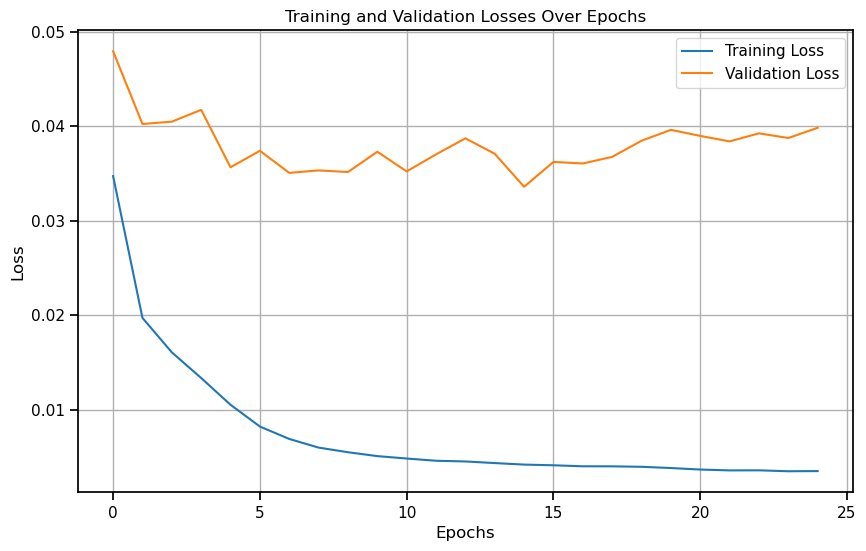

In [ ]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [ ]:
def calc_explained_variance(x, y, mnet, mnet_weights):
    """Compute the explained variance for a given dataset"""
    with torch.no_grad():
        # Process complete dataset as one batch.
        # Convert X_train and y_train to PyTorch tensors
        inputs = torch.tensor(x, device=device, dtype=torch.float32)
        targets = torch.tensor(y, device=device, dtype=torch.float32)

        # Forward pass to get predictions
        predictions = mnet(inputs, weights=mnet_weights)

        y_array = targets.detach().cpu().numpy()
        y_pred_array = predictions.detach().cpu().numpy()
     
        # Reshape tensors to 2D arrays (flatten the batch and sequence dimensions)
        y_pred_2D = y_pred_array.reshape(-1, y_pred_array.shape[-1])
        y_true_2D = y_array.reshape(-1, y_array.shape[-1])

        # Compute explained variance
        explained_var = explained_variance_score(y_true_2D, y_pred_2D)

    return explained_var

In [ ]:
subsets = ['Training', 'Validation', 'Test']

data_base = [[x_train_base, y_train_base],
             [x_val_base, y_val_base],
             [x_test_base, y_test_base]]

data_stim = [[x_train_stim, y_train_stim],
             [x_val_stim, y_val_stim],
             [x_test_stim, y_test_stim]]

In [ ]:
for index, [x,y] in enumerate(data_base):
    ev = calc_explained_variance(x, y, model, W_base)
    print('Explained variance for ', subsets[index], ' is : ', ev)


Explained variance for  Training  is :  0.9701679150263468
Explained variance for  Validation  is :  0.43597426017125446
Explained variance for  Test  is :  0.3171289761861165


In [ ]:
for index, [x,y] in enumerate(data_stim):
    ev = calc_explained_variance(x, y, model, W_stim)
    print('Explained variance for ', subsets[index], ' is : ', ev)

Explained variance for  Training  is :  0.9671011964480082
Explained variance for  Validation  is :  0.4343749483426412
Explained variance for  Test  is :  0.47608526547749835


In [ ]:
def reshape_to_eval_hnet(x,y, model, weights):
    x = to_t_eval(x) 
    y = to_t_eval(y)
    y_pred = model(x, weights = weights)
    y_array = y.detach().cpu().numpy()
    y_pred_array = y_pred.detach().cpu().numpy()

    # Reshape tensors to 2D arrays (flatten the batch and sequence dimensions)
    y_pred_2D = y_pred_array.reshape(-1, y_pred_array.shape[-1])
    y_true_2D = y_array.reshape(-1, y_array.shape[-1])
    
    return y_true_2D, y_pred_2D

In [ ]:
y_true_2D, y_pred_2D = reshape_to_eval_hnet (x_test_base, y_test_base, model, W_base)

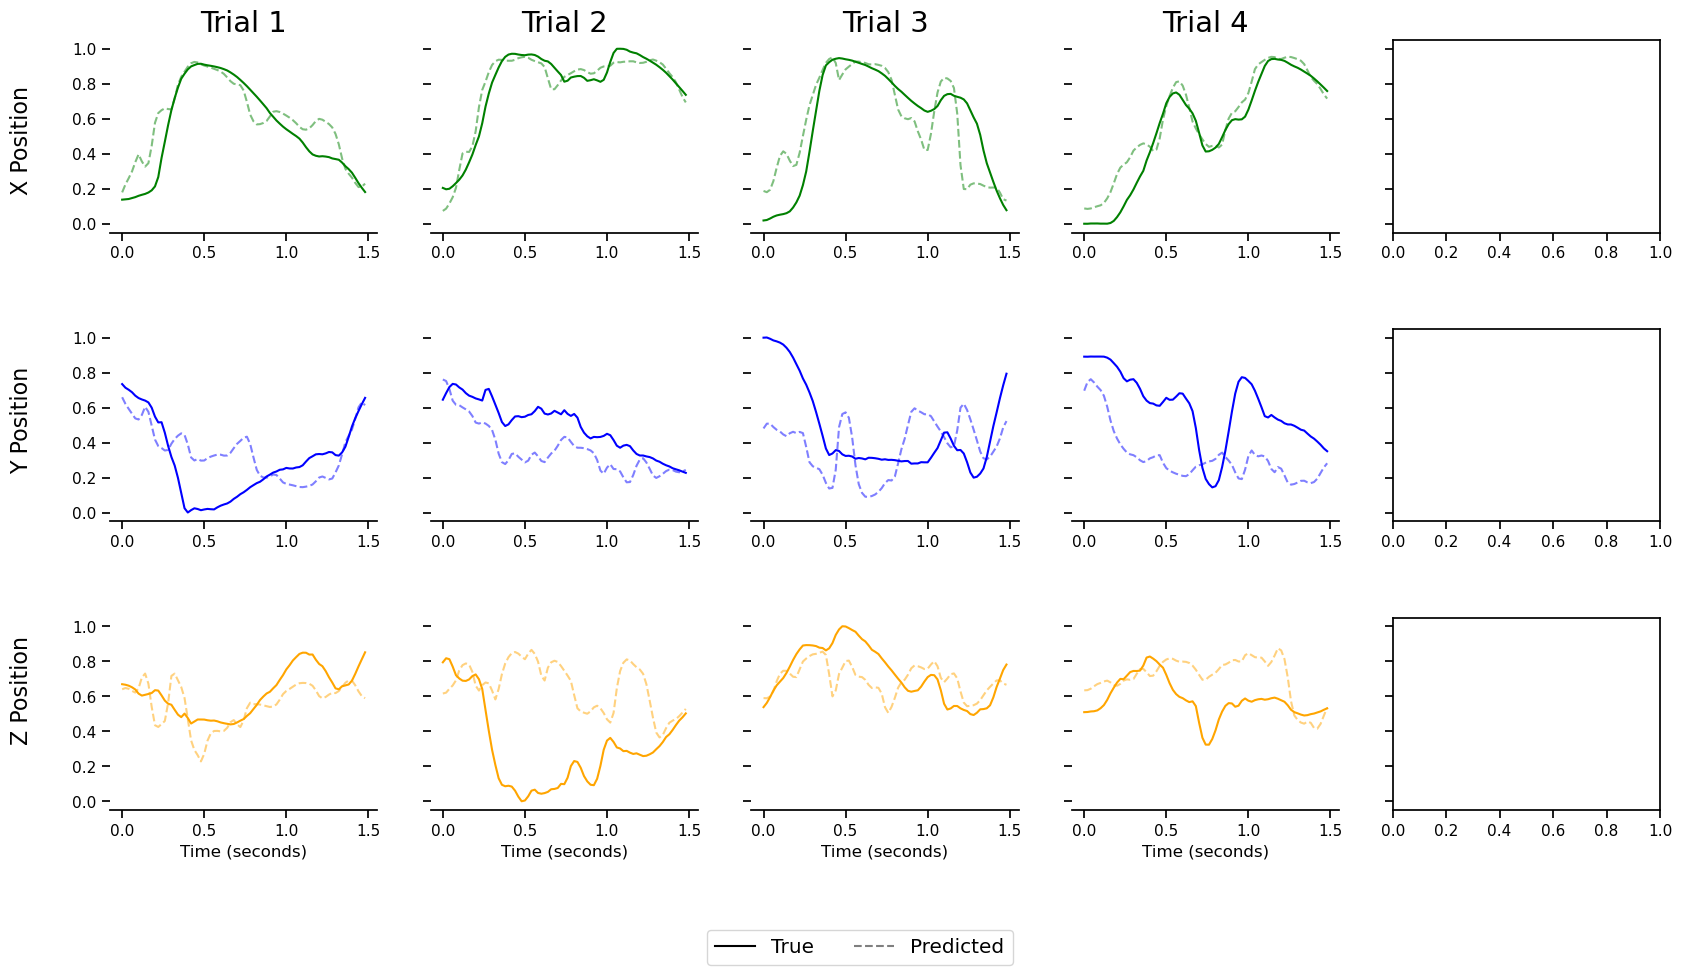

In [ ]:
visualize_LSTM_test(y_pred_2D, y_true_2D, seq_length = 75)

## Trying hypernetworks in chunks

This tutorial shows how to utilize a StructuredHMLP (a certain kind of hypernetwork that allows smart chunking) in combination with a ResNet.

In [79]:
from hypnettorch.hnets.chunked_mlp_hnet import ChunkedHMLP

In [80]:
net = SimpleRNN(n_in=num_features, rnn_layers=(hidden_units,), 
                  fc_layers_pre=(input_rec,), fc_layers=(num_dim_output,),
                use_lstm = True, no_weights = True).to(device) 

Creating a simple RNN with 12223 weights.


In [81]:
chunk_size = 1000
num_tasks = 2

In [82]:
hnet = ChunkedHMLP(net.param_shapes, chunk_size = chunk_size, chunk_emb_size=8, 
cond_chunk_embs=True, uncond_in_size=0, cond_in_size=12, layers=(40, 40), 
 num_cond_embs=num_tasks).to(device) 

Created Chunked MLP Hypernet with 13 chunk(s) of size 1000.
Hypernetwork with 43712 weights and 12223 outputs (compression ratio: 3.58).
The network consists of 43480 unconditional weights (43480 internally maintained) and 232 conditional weights (232 internally maintained).


In [83]:
train_losses, val_losses, W_base, W_stim = train_hypernet(
        net, hnet, y_train_base, x_train_base,
                y_train_stim,  x_train_stim,
                y_val_base,  x_val_base,
                y_val_stim,    x_val_stim,
                lr=0.001,
                lr_step_size=10,
                lr_gamma=0.9,
                sequence_length_LSTM= seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                regularizer = reg_hnet_noweights, 
                l1_ratio = 0.5,
                alpha = 1e-3, 
                chunks = True  )

Initializing hypernet with Chunked Hyperfan Init ...


/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/hypnettorch/hnets/chunked_mlp_hnet.py:793: UserWarning: Note, hypernetwork inputs should have an initial total variance (std) smaller than 0.026247 (0.162008) in order for this method to work properly.
  warn('Note, hypernetwork inputs should have an initial total ' +
/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/hypnettorch/hnets/chunked_mlp_hnet.py:812: UserWarning: Initial variance of 13/13 chunk embeddings had to be clipped.
  warn('Initial variance of %d/%d ' % (n_clipped, len(chunk_vars)) + \


Epoch 000 Train 1.8580 Val 0.2447
Epoch 001 Train 0.1224 Val 0.0985
Epoch 002 Train 0.0685 Val 0.0761
Epoch 003 Train 0.0552 Val 0.0711
Epoch 004 Train 0.0464 Val 0.0654
Epoch 005 Train 0.0415 Val 0.0622
Epoch 006 Train 0.0379 Val 0.0570
Epoch 007 Train 0.0359 Val 0.0573
Epoch 008 Train 0.0339 Val 0.0571
Epoch 009 Train 0.0321 Val 0.0552
Epoch 010 Train 0.0306 Val 0.0516
Epoch 011 Train 0.0288 Val 0.0516
Epoch 012 Train 0.0274 Val 0.0515
Epoch 013 Train 0.0264 Val 0.0526
Epoch 014 Train 0.0252 Val 0.0507
Epoch 015 Train 0.0245 Val 0.0500
Epoch 016 Train 0.0235 Val 0.0496
Epoch 017 Train 0.0223 Val 0.0494
Epoch 018 Train 0.0211 Val 0.0467
Epoch 019 Train 0.0201 Val 0.0492
Epoch 020 Train 0.0192 Val 0.0498
Epoch 021 Train 0.0190 Val 0.0496
Epoch 022 Train 0.0182 Val 0.0506
Decrease LR
Epoch 023 Train 0.0176 Val 0.0477
Epoch 024 Train 0.0171 Val 0.0469
Epoch 025 Train 0.0167 Val 0.0495
Epoch 026 Train 0.0163 Val 0.0473
Epoch 027 Train 0.0158 Val 0.0493
Decrease LR


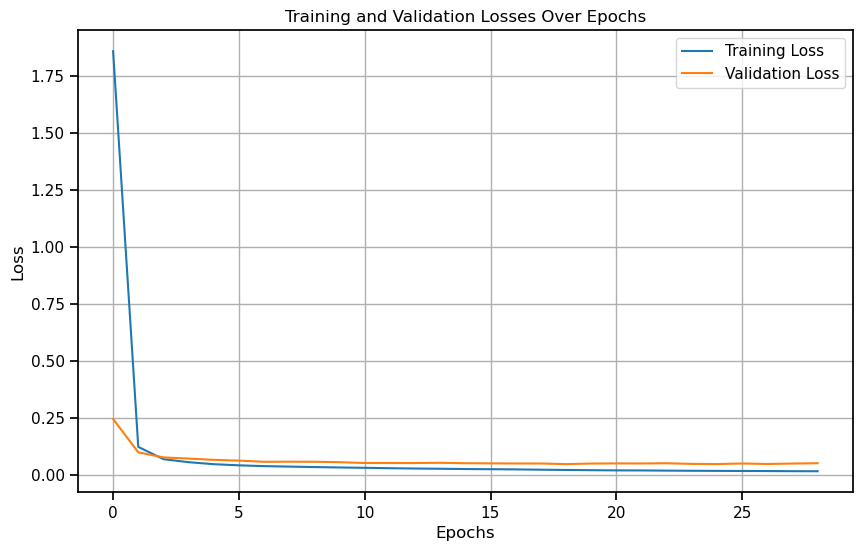

In [84]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [85]:
subsets = ['Training', 'Validation', 'Test']

data_base = [[x_train_base, y_train_base],
             [x_val_base, y_val_base],
             [x_test_base, y_test_base]]

data_stim = [[x_train_stim, y_train_stim],
             [x_val_stim, y_val_stim],
             [x_test_stim, y_test_stim]]

In [86]:
for index, [x,y] in enumerate(data_base):
    ev = calc_explained_variance(x, y, net, W_base)
    print('Explained variance for ', subsets[index], ' is : ', ev)


Explained variance for  Training  is :  0.5903700391451517
Explained variance for  Validation  is :  0.495531698067983
Explained variance for  Test  is :  0.4317145148913066


In [87]:
for index, [x,y] in enumerate(data_stim):
    ev = calc_explained_variance(x, y, net, W_stim)
    print('Explained variance for ', subsets[index], ' is : ', ev)

Explained variance for  Training  is :  0.6629307866096497
Explained variance for  Validation  is :  0.3053845961888631
Explained variance for  Test  is :  0.1252118945121765
